# Introduction
This is a reproduction of [_Software for Simulating Lunar Surface Hydration Measurements for Multispectral Lidar at 3 µm_](./Earth%20and%20Space%20Science%20-%202022%20-%20Cremons.pdf)
using Python instead of Matlab. The goal is to reproduce the figures and results from the data published by Cremons, et. al that accompanied their paper.

> Cremons, Daniel R., “Software for Simulating Lunar Surface Hydration Measurements for Multispectral Lidar at 3 µm”. Zenodo, Jul. 01, 2022. doi: [10.5281/zenodo.6025377](https://doi.org/10.1029/2022EA002277).

The goal of this project is to learn by doing, and to reproduce the figures in a manner than is more broadly accessible. Comments and opinions expressed in the code and supporting text in this notebook are my own.

In [1]:
%load_ext autoreload
%autoreload 2


# Characteristics of Observed Reflectance Spectra


In [3]:
# external modules
import pandas as pd
from pathlib import Path

# local module for working with spectral data
import spectra


## Samples of real regolith mixtures

First we parse the 5 spectra from samples of regolith that were used in the manuscript.

<Axes: title={'center': 'Processed Lab Spectra'}, xlabel='Wavelength (μm)', ylabel='Reflectance'>

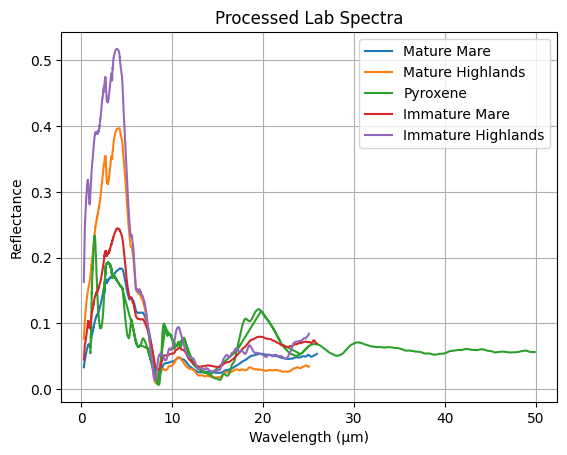

In [16]:
# Import reflectance spectra (processed to remove hydration and organics)
samples = {
    'Mature Mare': Path('../data/Mare_70181_Spectra.txt'),
    'Mature Highlands': Path('../data/Highlands_62231_Spectra.txt'),
    'Pyroxene': Path('../data/Apollo15Sample15555ReddishBrownPyroxeneB.txt'),
    'Immature Mare': Path('../data/Mare_71061_Spectra.txt'),
    'Immature Highlands': Path('../data/Highlands_61221_Spectra.txt'),
}

lab_spectra = []
for name, path in samples.items():
    lab_spectra.append(
        spectra.spectrum_from_file(path, name, header=2, delimiter='\t')
    )

endmember_spectra = pd.concat(lab_spectra, axis=1)

endmember_spectra.plot(
    title='Processed Lab Spectra',
    xlabel='Wavelength (μm)',
    ylabel='Reflectance',
    grid=True,
    legend=True,
)


So far, so good. The imported datasets match what is shown in **Figure 1a** of the manuscript after limiting the x-axis to the spectrum of interest.

It's not clear to me what the units of reflectance are in this data, as it is unlabeled in the source data files. I looked around briefly in the source dataset ([NASA RELAB](https://sites.brown.edu/relab/lunar-rock-and-mineral-characterization-database/)) and related publications ([source](https://www.researchgate.net/publication/253034096_RELAB_Reflectance_Experiment_Laboratory_A_NASA_multiuser_spectroscopy_facility)) but didn't see anything obvious. This does not undermine the analysis, though.

I observed the features described in the manuscript in the plotted data.

<Axes: title={'center': 'Figure 1a'}, xlabel='Wavelength (μm)', ylabel='Reflectance'>

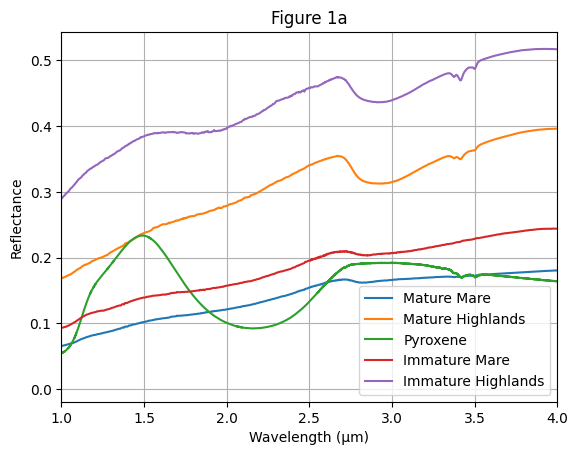

In [17]:
# Figure 1a
endmember_spectra.plot(
    title='Figure 1a',
    xlabel='Wavelength (μm)',
    ylabel='Reflectance',
    grid=True,
    legend=True,
    xlim=(1, 4),
)


## Hydrated mid-ocean-ridge basalt (MORB) glass
Next we set up the conditions of the experiment:
1. Hydrated mid-ocean-ridge basalt (MORB) glass was heated in a step-wise fashion to four setpoint temperatures.
2. Hydration of the samples was measured as parts-per-million of water.

The data for these observations is provided as tables of recorded reflectance as a percentage over a frequency spectrum with units 1/cm. Each of the four heating experiments has a corresponding hydration measurement.

After ingesting the tabular data, we need to convert the units to decimal fractions of reflectance response over a spectral range in microns.

<Axes: title={'center': 'Heated MORB spectra'}, xlabel='Wavelength (μm)', ylabel='Reflectance'>

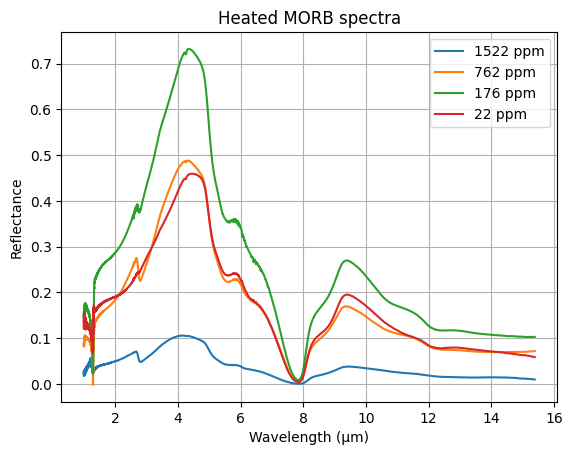

In [6]:
# Temperature of step-heating experiment in degrees Celsius
temperature = [650, 700, 750, 800]
# Total water measured from step-heating experiments in ppm
water_ppm = [1522, 762, 176, 22]

experiments = zip(temperature, water_ppm)

# Import observations of MORB step-wise heating reflectance spectra
imported_reflectances = []
for deg_c, ppm in experiments:
    MORB_spectrum = spectra.spectrum_from_file(
            Path(f"../data/{deg_c}^oC.csv"),
            name=f'{ppm} ppm')
    MORB_spectrum.index = 1e4 / MORB_spectrum.index  # 1/cm to microns
    MORB_spectrum = MORB_spectrum / 100  # percent to decimal
    
    # since we converted frequency to wavelength, need to resort data
    MORB_spectrum = MORB_spectrum.sort_index()
    imported_reflectances.append(MORB_spectrum)

heated_MORB_spectra = pd.concat(imported_reflectances, axis=1)


It's curious how the supplied datasets span a very wide spectral range range, up 0.5-15+ microns or so, but the spectrum of interest is 1-4 microns. Perhaps this study is one of many, and is simply focused on a portion of the spectrum.

<Axes: title={'center': 'Heated MORB spectra'}, xlabel='Wavelength (μm)', ylabel='Reflectance'>

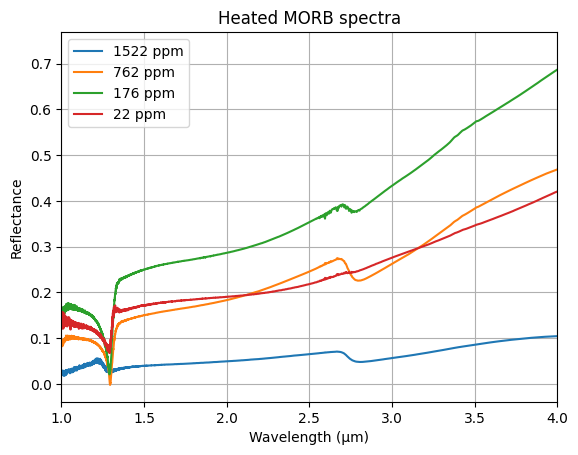

In [19]:
heated_MORB_spectra.plot(
    title='Heated MORB spectra',
    xlabel='Wavelength (μm)',
    ylabel='Reflectance',
    grid=True,
    legend=True,
    xlim=(1,4),
)


The MORB reflectance over the spectrum of interest (1-4 micron) looks very different from the "processed" traces in Figure 1b. In the authors' code the MORB spectra are normalized to the 22 ppm reflectance spectrum. The "raw" heated MORB spectra also contains strange (to me) features below 1.5 microns.

The manuscript attributes these features to the presence of unquantified hydration and organic doublets in this part of the spectrum, and substitutes parts of the reflectance spectra with linearly fitted data.

The first data processing operation that is performed is to replace the spectra below 1.6 micron with another reflectance spectrum. It's a bit strange to _replace_ a portion of the observations with other observations, but in this case it feels analagous to an HDR composite photo.

<Axes: title={'center': 'MORB D38A low wavelengths'}, xlabel='Wavelength (μm)', ylabel='Reflectance'>

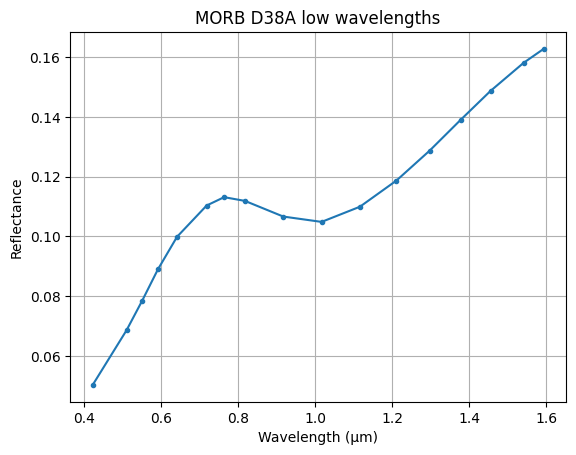

In [7]:
# Low wavelength portion of MORB spectrum (<1.5 microns)
MORB_D38A_LowLam = spectra.spectrum_from_file(
    Path("../data/Morb_D38A_Low_wavelength.txt"),
    name='MORB D38A low wavelengths',
)
MORB_D38A_LowLam.plot(
    title='MORB D38A low wavelengths',
    xlabel='Wavelength (μm)',
    ylabel='Reflectance',
    grid=True,
    marker='.',
)


Now we normalize the heated MORB spectra to the reflectance of the least hydrated mixture.

In these plots I've turned on datapoint markers to highlight the relative sampling resolution.

<Axes: title={'center': 'Normalized MORB spectra'}, xlabel='Wavelength (μm)', ylabel='Reflectance'>

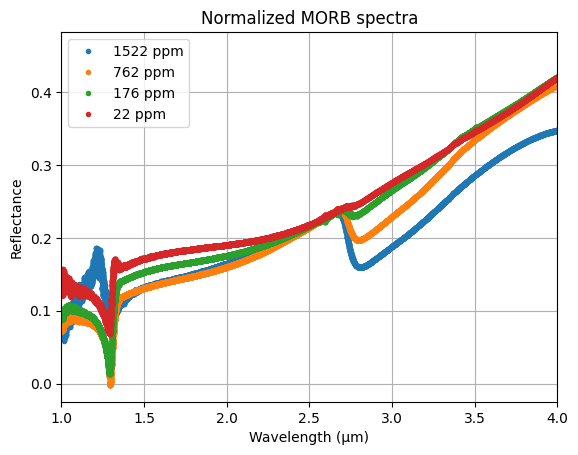

In [8]:
# Normalize all MORB spectra to the reflectance at 2.6 microns at the
# lowest water amount and highest temperature (22 ppm, 800 C)
scale_factor = spectra.get_normalization_factor(
    heated_MORB_spectra['22 ppm'], 2.6)
normalized_spectra = pd.DataFrame()
for spectrum in heated_MORB_spectra.columns:
    MORB_spectrum = heated_MORB_spectra[spectrum]
    
    norm_factor = spectra.get_normalization_factor(MORB_spectrum, 2.6)
    norm_spectrum = MORB_spectrum * (scale_factor / norm_factor)
    normalized_spectra[spectrum] = norm_spectrum

normalized_spectra.plot(
    title='Normalized MORB spectra',
    xlabel='Wavelength (μm)',
    ylabel='Reflectance',
    grid=True,
    legend=True,
    xlim=(1, 4),
    marker='.',
    linewidth=0,
)


Next, to remove the apparent artifacts below 2.6 micron. This is done by simply replacing the data below 2.6 micron with the least hydrated reflectance spectrum, 22 ppm.

Even the 22 ppm MORB spectrum has odd behavior between 1.0-1.5 microns, though. This region of the spectrum is replaced with the observations that focused on 1.0-1.6 microns (`Morb_D38A_Low_wavelength.txt`), which also has to be normalized to mesh with the 22 ppm reflectance spectrum at the boundary between those datasets.

While there is some pretty heavy processing done on the spectra below 2.6 micron, the focus of this study is the 3-4 micron range. The processing is done to show relative characteristics between spectra without including other features that may distract from the analysis itself.

<Axes: title={'center': 'Simplified MORB spectra'}, xlabel='Wavelength (μm)', ylabel='Reflectance'>

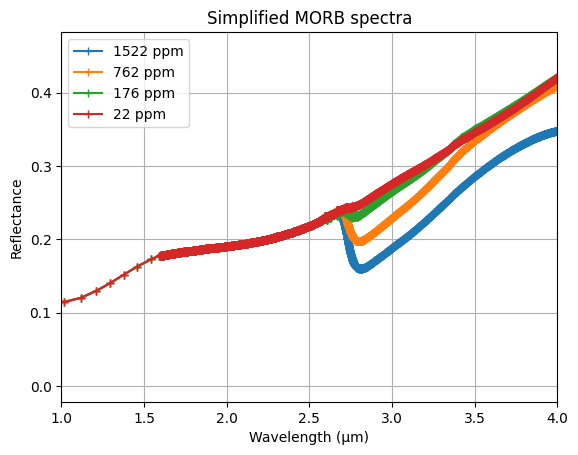

In [9]:
# Replace spectrum below 2.6 micron with 650C reflectance
# to isolate 3 micron feature changes and stitch in low wavelengths
mid_spectrum = normalized_spectra['22 ppm'].loc[
    MORB_spectrum.index < 2.6]
mid_spectrum = mid_spectrum.loc[mid_spectrum.index > 1.6]

# normalize lower spectrum to meet up with the rest of the spectrum
stitch_factor = spectra.get_normalization_factor(mid_spectrum, 1.6) / \
                spectra.get_normalization_factor(MORB_D38A_LowLam, 1.6)
lower_spectrum = MORB_D38A_LowLam * stitch_factor

simple_spectra = pd.DataFrame()
for spectrum in normalized_spectra.columns:
    MORB_spectrum = normalized_spectra[spectrum]
    unified_spectrum = mid_spectrum.combine_first(lower_spectrum)
    upper_spectrum = normalized_spectra[spectrum].loc[
        normalized_spectra.index > 2.6]

    simple_spectra[spectrum] = unified_spectrum.combine_first(upper_spectrum)

simple_spectra.plot(
    title='Simplified MORB spectra',
    xlabel='Wavelength (μm)',
    ylabel='Reflectance',
    grid=True,
    legend=True,
    xlim=(1, 4),
    marker='+'
)


Interpolating the spectra between 1-4 microns in 5 nm intervals yields **Figure 1b** as it appears in the manuscript.

<Axes: title={'center': 'Full MORB spectra'}, xlabel='Wavelength (μm)', ylabel='Reflectance'>

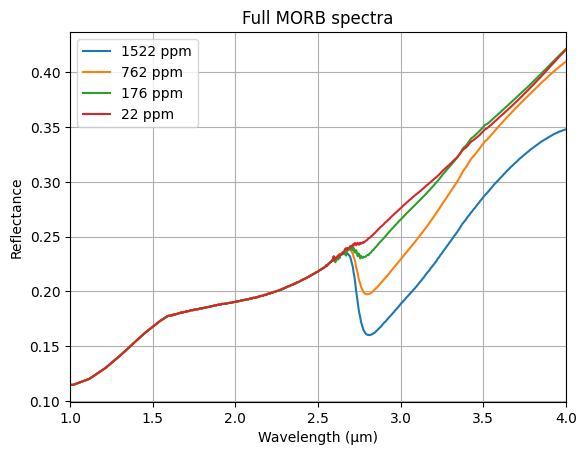

In [10]:

# define wavelength range and spacing for simulations as
# 1-4 micron at 5nm intervals
WLS = np.linspace(1, 4, 601)

# interpolate along our sampling grid of interest
interpolated_spectra = simple_spectra.apply(
    spectra.interpolate_series, args=[WLS], axis=0)


# Figure 1b
interpolated_spectra.plot(
    title='Full MORB spectra',
    xlabel='Wavelength (μm)',
    ylabel='Reflectance',
    grid=True,
    legend=True,
    xlim=(1, 4),
)


## Calculate SSA using Hapke Model

Use Hapke model to convert from laboratory reflectance to single
scattering albedo using reflectance and scattering asymmetry
factor (p) of 0.81 (see manuscript for details on Hapke model)

In [11]:
from functools import partial

# local module for hapke model
import hapke


<Axes: title={'center': 'Estimated MORB Single-Scattering Albedo'}, xlabel='Wavelength (μm)', ylabel='SSA'>

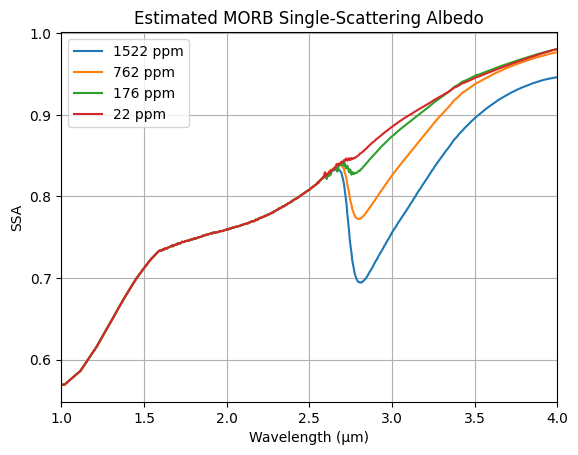

In [12]:
hapke_model = partial(hapke.ssa_from_reflectance, 
    asymmetry_factor = 0.81,
    emission_angle = 0,
    incident_angle = 30,
    phase_angle = 30,
    filling_factor = 0.41,
    initial_guess = 0.5
)
ssa_MORB = pd.DataFrame()
for ppm in interpolated_spectra:
    ssa_MORB[ppm] = interpolated_spectra[ppm].apply(hapke_model)

ssa_MORB.plot(
    title='Estimated MORB Single-Scattering Albedo',
    xlabel='Wavelength (μm)',
    ylabel='SSA',
    grid=True,
    legend=True,
    xlim=(1, 4),
)


<Axes: >

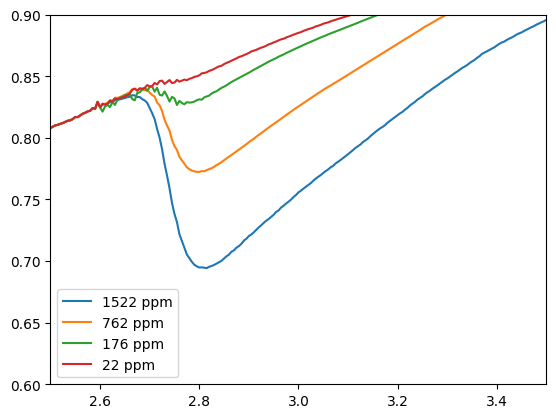

In [13]:
ssa_MORB.plot(xlim=(2.5,3.5), ylim=(.6,.9))


In [14]:
# set the total number of simulations to run
num_spectra = 100
